# ADDI Segmentation Reserch

В этом исследовании решается задача  сегментации медицинских снимков
Датасет лежит в открытом доступе по ссылке: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>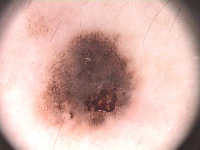</td><td>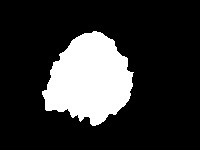</td></tr></table>



В нем представлены фотографии двух типов **поражений кожи:** меланома и родинки.
В данном исследовании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Для выполнения ноутбука в Colab:

In [ ]:
# for google collab:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
!ls
get_ipython().system_raw("unrar x PH2Dataset.rar")

root = 'PH2Dataset'

Для выполнения ноутбука в Kaggle:

In [ ]:
# for kaggle:
# add dataset to notebook: https://www.kaggle.com/datasets/synked/ph2-modified
root='/kaggle/input/ph2dataset/PH2Dataset/PH2Dataset'

In [4]:
images = []
lesions = []
from skimage.io import imread
import os


for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, нарисуем несколько изображений

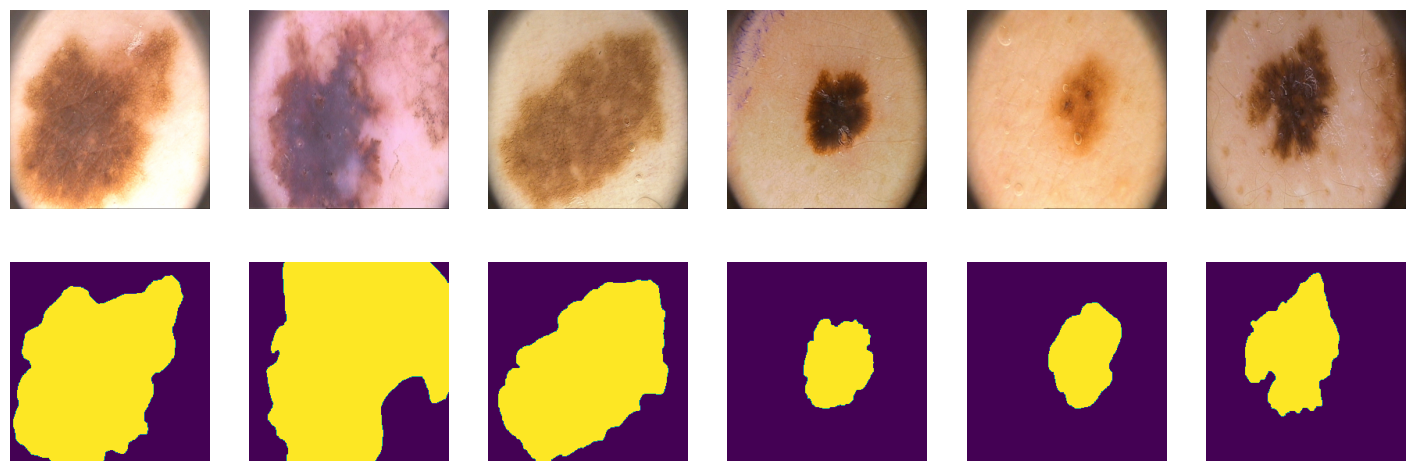

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Задача состоит в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и сравнить различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet

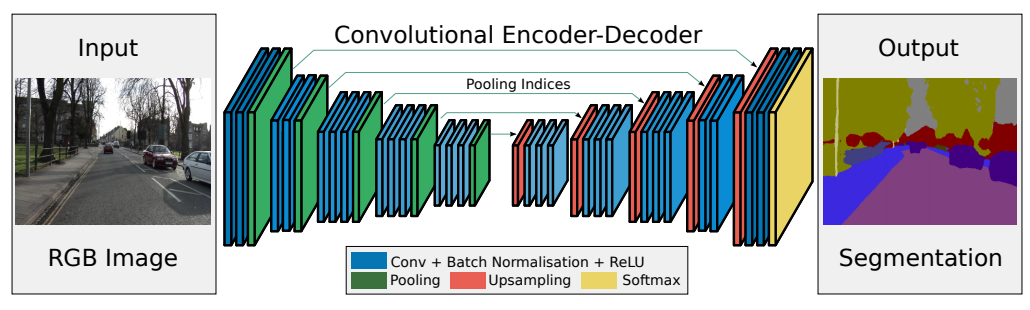

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Первая архитектура для реализации это SegNet:

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
class SegNet(nn.Module):
    ''' 
    Seg_Net
    '''
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.upsample2 = nn.Upsample(128)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.upsample3 = nn.Upsample(256)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding='same'),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        up0 = self.upsample0(b)
        d0 = self.dec_conv0(up0)

        up1 = self.upsample1(d0)
        d1 = self.dec_conv1(up1)

        up2 = self.upsample2(d1)
        d2 = self.dec_conv2(up2)

        up3 = self.upsample3(d2)
        d3 = self.dec_conv3(up3)   # no activation

        return d3


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = (torch.sigmoid(outputs) > 0.5).int()

    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded


Напишем функцию для применения метрики к переданной модели:

In [19]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)).detach().cpu()
        scores += metric(Y_pred, Y_label).mean().item()

    return scores/len(data)

## Функция потерь

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [16]:
def bce_loss(y_real, y_pred):
    loss = y_pred-y_pred*y_real+torch.log(1+torch.exp(-y_pred))
    return loss.mean()


---

## Основной момент: обучение
Напишем отдельный класс для тренировок моделей. Класс ModelTrainer() будет сохранять информацию о точности и loss, а так же визуализировать всю информацию. В дальнейшем остальные модели тоже будем обучать с помощью этого класса:

In [116]:
class ModelTrainer():
    def __init__(self) -> None:
        self.train_hist = np.array([[0, 0]])
        self.eval_hist = np.array([[0, 0]])
        self.current_epoch = 1
        self.max_epoch = 0
        self.loss_fn = None
        self.score_fn = None
        pass

    def eval_time(func):
        def wrapper(*args, **kwargs):
            tic = time()
            func(*args, **kwargs)
            toc = time()
            print('time: %d sec' % (toc-tic))
        return wrapper

    @eval_time
    def train_epoch(self, opt, scheduler, data_tr):
        self.model.train()
        avg_loss, avg_score = 0, 0
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = self.model(X_batch)
            loss = self.loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            loss, score = self.get_loss_and_score(Y_batch, Y_pred)
            avg_loss += loss
            avg_score += score

        scheduler.step()
        avg_loss = avg_loss / len(data_tr)
        avg_score = avg_score / len(data_tr)
        self.train_hist = np.append(self.train_hist, [[avg_loss, avg_score]], axis=0)
        print('loss: %f,' % avg_loss)

    def eval_epoch(self, X_val, Y_val):
        self.model.eval()
        Y_hat = self.model(X_val.to(device)).detach().cpu()
        loss, score = self.get_loss_and_score(Y_val, Y_hat)
        self.eval_hist = np.append(self.eval_hist, [[loss, score]], axis=0)
        return Y_hat

    def get_loss_and_score(self, Y_val, Y_hat):
        loss = self.loss_fn(Y_val, Y_hat).detach().cpu().numpy()
        Y_pred = (Y_hat > 0).int()
        score = self.score_fn(Y_val, Y_pred).detach().cpu().numpy().mean()
        return loss, score

    def set_params(self, model, loss_fn, score_fn, epochs):
        self.max_epoch += epochs
        self.model = model
        self.loss_fn = loss_fn
        self.score_fn = score_fn

    def print_text_info(self):
        print('* Epoch %d/%d' % (self.current_epoch, self.max_epoch))
        print('* Train loss: %f  |  train acc: %f' %
              (self.train_hist[-1][0], self.train_hist[-1][1]))
        print('* Eval  loss: %f  |  eval  acc: %f' %
              (self.eval_hist[-1][0], self.eval_hist[-1][1]))

    def train(self, model, opt, scheduler, loss_fn, score_fn, epochs, data_tr, data_val, silent=False):
        self.set_params(model, loss_fn, score_fn, epochs)
        X_val, Y_val = next(iter(data_val))

        for epoch in range(epochs):
            self.train_epoch(opt, scheduler, data_tr)

            Y_hat = self.eval_epoch(X_val, Y_val)

            data = [X_val, Y_val, Y_hat]
            if not silent:
                self.plot_image_and_graph(epoch=epoch, max_epoch=epochs, data=data)
                self.print_text_info()
            self.current_epoch += 1

    def get_binary_pred(self, logits):
        return (torch.sigmoid(logits) > 0.5).int()

    def plot_image_and_graph(self, epoch, max_epoch, data):
        X_val, Y_val, Y_hat = data
        clear_output(wait=True)
        plt.figure(figsize=(15, 10))
        shape = (6, 6)
        for k in range(6):
            sample_img = np.rollaxis(X_val[k].numpy(), 0, 3)
            self.plot_image(shape, (k, 0), sample_img, title='Real')
            self.plot_image(shape, (k, 1), Y_val[k, 0], title='Label')
            self.plot_image(shape, (k, 2), Y_hat[k, 0], title='Logits', title_color='red')
            y_pred = self.get_binary_pred(Y_hat)
            self.plot_image(shape, (k, 3), y_pred[k, 0], title='Prediction', title_color='red')

        y = np.column_stack([self.train_hist[:, 0], self.eval_hist[:, 0]])[1:]
        x = range(1, len(y)+1)
        self.plot_graph(shape, (0, 4), x, y, title='Loss')
        plt.xticks()

        y = np.column_stack([self.train_hist[:, 1], self.eval_hist[:, 1]])[1:]
        x = range(1, len(y)+1)
        self.plot_graph(shape, (3, 4), x, y, title='Score')
        plt.suptitle('epoch: %d / %d' % (self.current_epoch, self.max_epoch))
        plt.show()

    def plot_image(self, shape, loc, data, title, title_color='blue'):
        ax = plt.subplot2grid(shape=shape, loc=loc, colspan=1)
        plt.imshow(data, cmap='gray')
        if loc[0]:
            title = ''
        plt.title(title, color=title_color)
        plt.axis('off')

    def plot_graph(self, shape, loc, x, y, title):
        plt.subplot2grid(shape=shape, loc=loc, rowspan=3, colspan=2)
        plt.plot(x, y, label=['Train', 'Validation'])
        if y.max() > 1:
            plt.ylim((0, 2))
        if loc[0] == 3:
            plt.xticks(x, labels=x)
            plt.xlabel('epoch')
        else:
            plt.xticks(x, labels='')
        plt.grid(True, axis='x')
        plt.legend()
        plt.title(title)


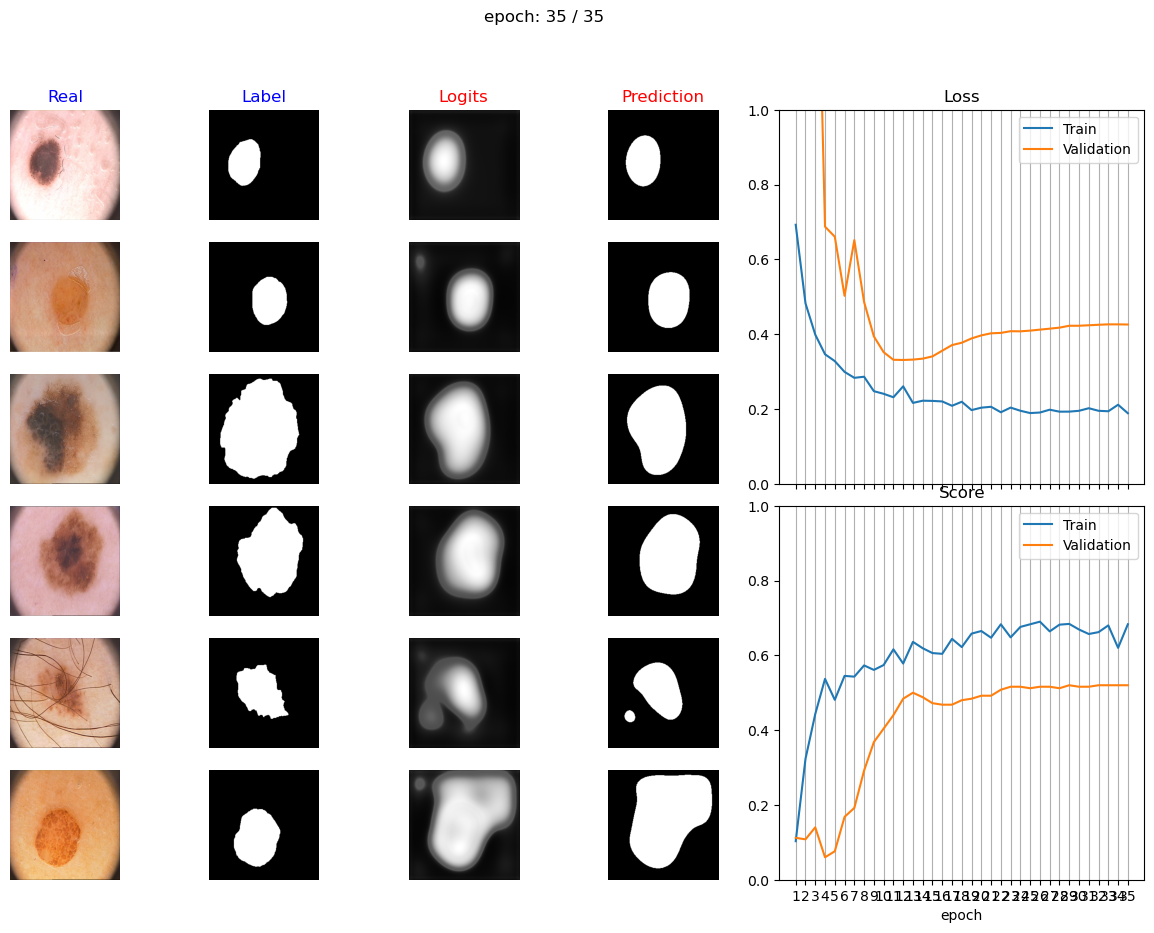

* Epoch 35/35
* Train loss: 0.188475  |  train acc: 0.683000
* Eval  loss: 0.425696  |  eval  acc: 0.520000


In [74]:
model_bce = SegNet().to(device)

max_epochs = 35
optimizer = torch.optim.Adam(model_bce.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

segnet_model_trainer = ModelTrainer()

segnet_model_trainer.train(model_bce, optimizer, exp_lr_scheduler,
                           bce_loss, iou_pytorch, max_epochs, data_tr, data_val)


In [29]:
score_model(model_bce, iou_pytorch, data_val)

0.5659999549388885

По графикам видно что точность на валидации перестаёт расти, а вот точность на трейне постепенно начинает увеличиваться. Это значит что сеть начинает переобучаться.

-----------------------------------------------------------------------------------------

## Другие функции потерь 

Реализуем другие функции потерь:  
`DICE` и `Focal loss.`   
Посмотрим как эти функции влияют на наши модели.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

In [30]:
def dice_loss(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = torch.sigmoid(y_pred).view(-1)
    SMOOTH = 1
    num = 1
    den = (2*(y_real*y_pred).sum()+SMOOTH)/((y_real+y_pred).sum()+SMOOTH)
    res = 1-num*den
    return res


Проводим тестирование:

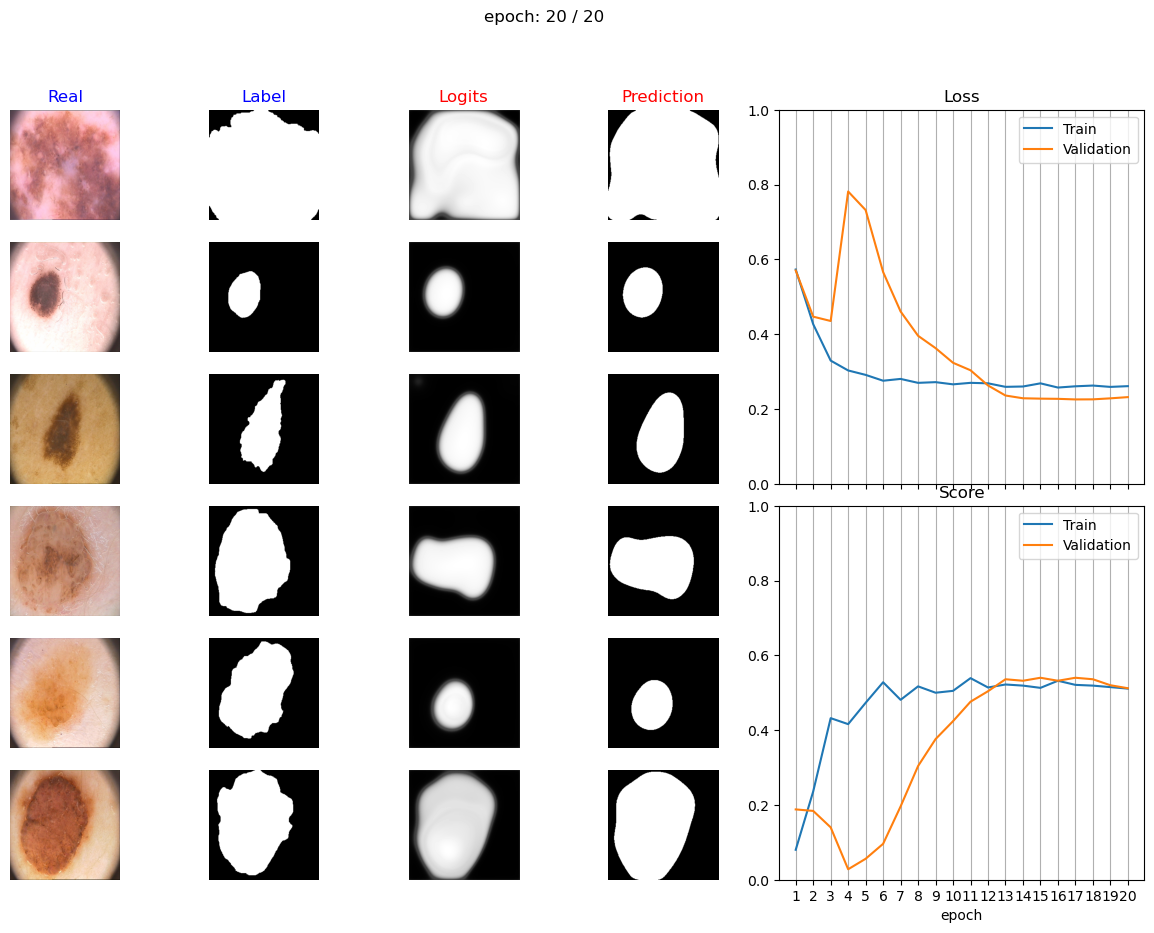

* Epoch 20/20
* Train loss: 0.260886  |  train acc: 0.511000
* Eval  loss: 0.231573  |  eval  acc: 0.512000


In [108]:
model_dice = SegNet().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(model_dice.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_trainer_dice = ModelTrainer()

model_trainer_dice.train(model_dice, optimizer, exp_lr_scheduler,
                         dice_loss, iou_pytorch, max_epochs, data_tr, data_val)


In [109]:
score_model(model_dice, iou_pytorch, data_val)

0.484000027179718

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Примем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [33]:
def focal_loss(y_real, y_pred, eps=1e-5, gamma=2):
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.clamp(y_pred, eps, 1-eps)

    loss = (1-y_pred)**gamma*y_real*torch.log(y_pred)+(1-y_real)*torch.log(1-y_pred)
    return -loss.mean()


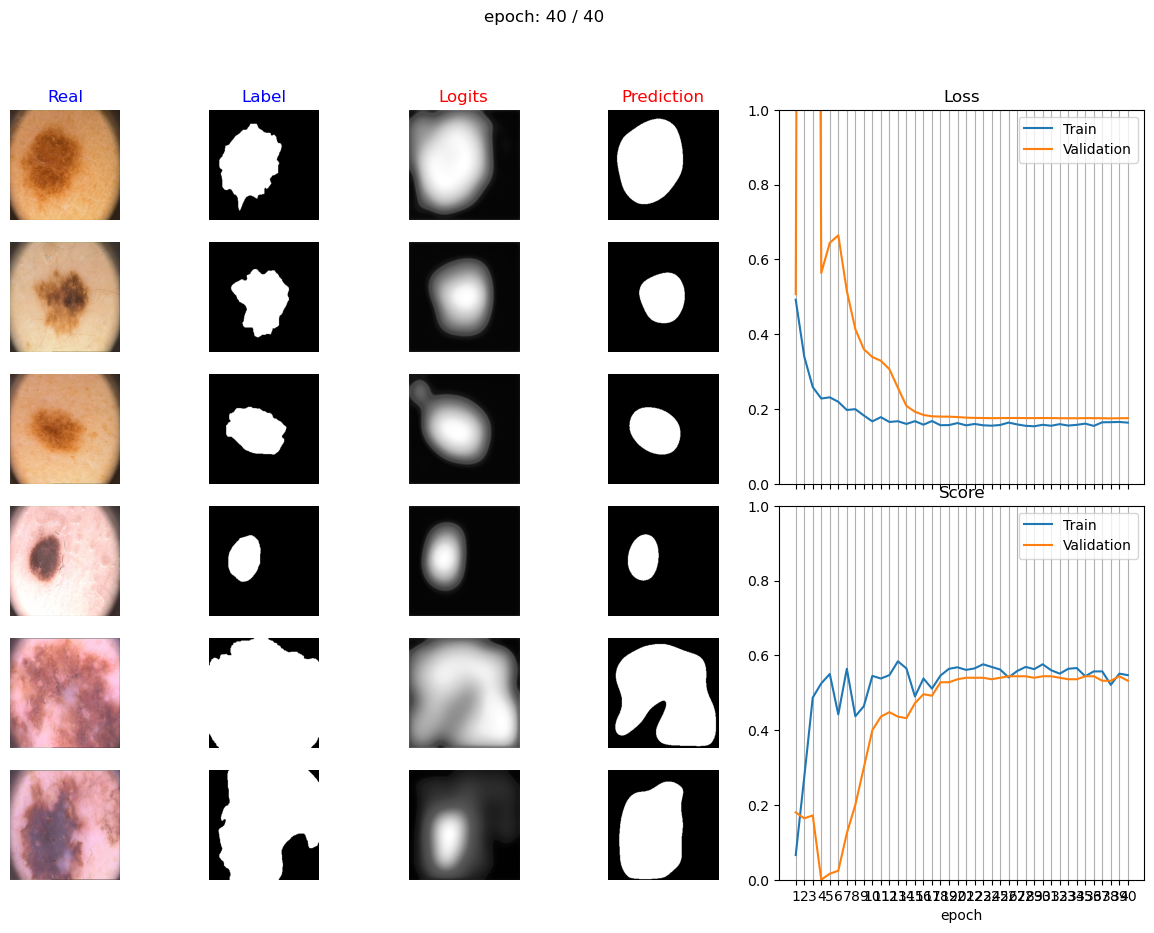

* Epoch 40/40
* Train loss: 0.163354  |  train acc: 0.547000
* Eval  loss: 0.175255  |  eval  acc: 0.532000


In [111]:
model_focal = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_focal.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_trainer_focal = ModelTrainer()

model_trainer_focal.train(model_focal, optimizer, exp_lr_scheduler,
                          focal_loss, iou_pytorch, max_epochs, data_tr, data_val)


In [35]:
score_model(model_focal, iou_pytorch, data_val)

0.515999972820282

Так же реализован ещё один лосс описанный в статье:   
[Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)"  
В статье использовался суммарный лосс при классификации изображения и лосс при сегментации(с регуляризацией). Т.к. у нас задача сегментации изображения то вместо классификациионного лосса используем BCE-loss и добавим к нему HYBRID FULLY AND WEAKLY SUPERVISED REGULARIZATION из статьи:



$$\mathcal L_{HybridLoss}(y, \hat y) = L_{BCE}(y, \hat y)+\lambda(L_{FSP}(y, \hat y)+(L_{sparsity}(\hat y)+\gamma L_{contiguity}(\hat y))).$$

In [37]:
def bce_hybrid_sup_regul(y_real, y_pred, lambda_coef=2, gamma=1):
    y_pred = torch.sigmoid(y_pred)

    bce_loss = (y_pred-y_pred*y_real+torch.log(1+torch.exp(-y_pred))).mean()

    part_loss = ((y_real-y_pred)**2).mean()

    sparcity_loss = y_pred.abs().mean()

    row = F.pad(y_pred, [1, 0, 0, 0], value=0)-F.pad(y_pred, [0, 1, 0, 0], value=0)
    column = F.pad(y_pred, [0, 0, 1, 0], value=0)-F.pad(y_pred, [0, 0, 0, 1], value=0)
    contiguity_loss = column.abs().mean()+row.abs().mean()

    loss = bce_loss+lambda_coef*(part_loss+(sparcity_loss+gamma*contiguity_loss))

    return loss


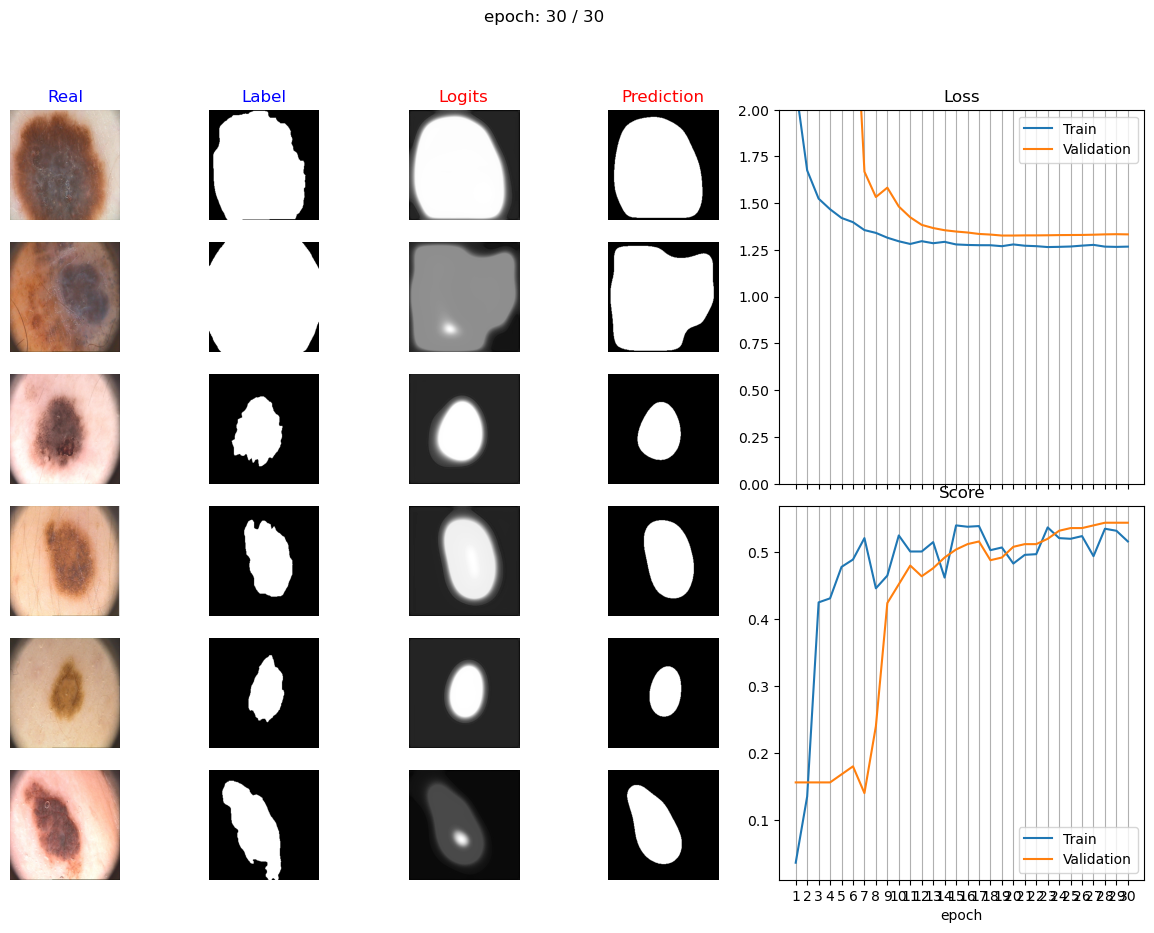

* Epoch 30/30
* Train loss: 1.267905  |  train acc: 0.516000
* Eval  loss: 1.333423  |  eval  acc: 0.544000


In [117]:
model_bce_hybrid = SegNet().to(device)

max_epochs = 30
optimizer = torch.optim.Adam(model_bce_hybrid.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_trainer_bce_hybrid = ModelTrainer()

model_trainer_bce_hybrid.train(model_bce_hybrid, optimizer, exp_lr_scheduler,
                               bce_hybrid_sup_regul, iou_pytorch, max_epochs, data_tr, data_val)


-----------------------------------------------------------------------------------------

# U-Net

Так же реализуем архитектуру:[**U-Net**](https://arxiv.org/abs/1505.04597) и затем сравним её с другими моделями.

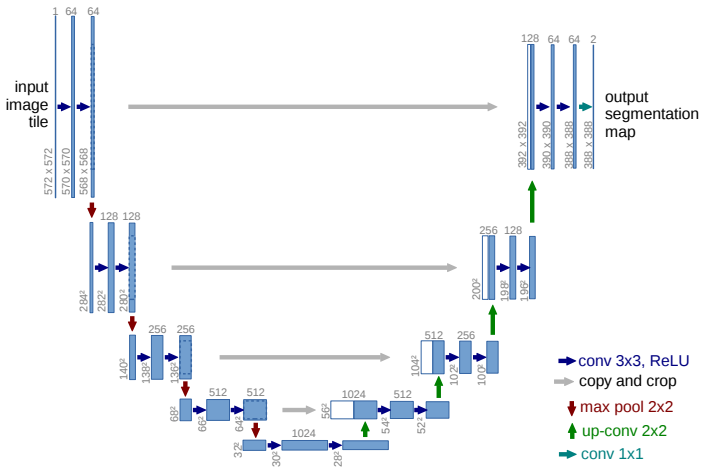


* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [39]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.upsample2 = nn.Upsample(128)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.upsample3 = nn.Upsample(256)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding='same'),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        up0 = self.upsample0(b)
        up0 = torch.concat([up0, e3], dim=1)
        d0 = self.dec_conv0(up0)

        up1 = self.upsample1(d0)
        up1 = torch.concat([up1, e2], dim=1)
        d1 = self.dec_conv1(up1)

        up2 = self.upsample2(d1)
        up2 = torch.concat([up2, e1], dim=1)
        d2 = self.dec_conv2(up2)

        up3 = self.upsample3(d2)
        up3 = torch.concat([up3, e0], dim=1)
        d3 = self.dec_conv3(up3)   # no activation

        return d3


In [40]:
unet_model = UNet().to(device)

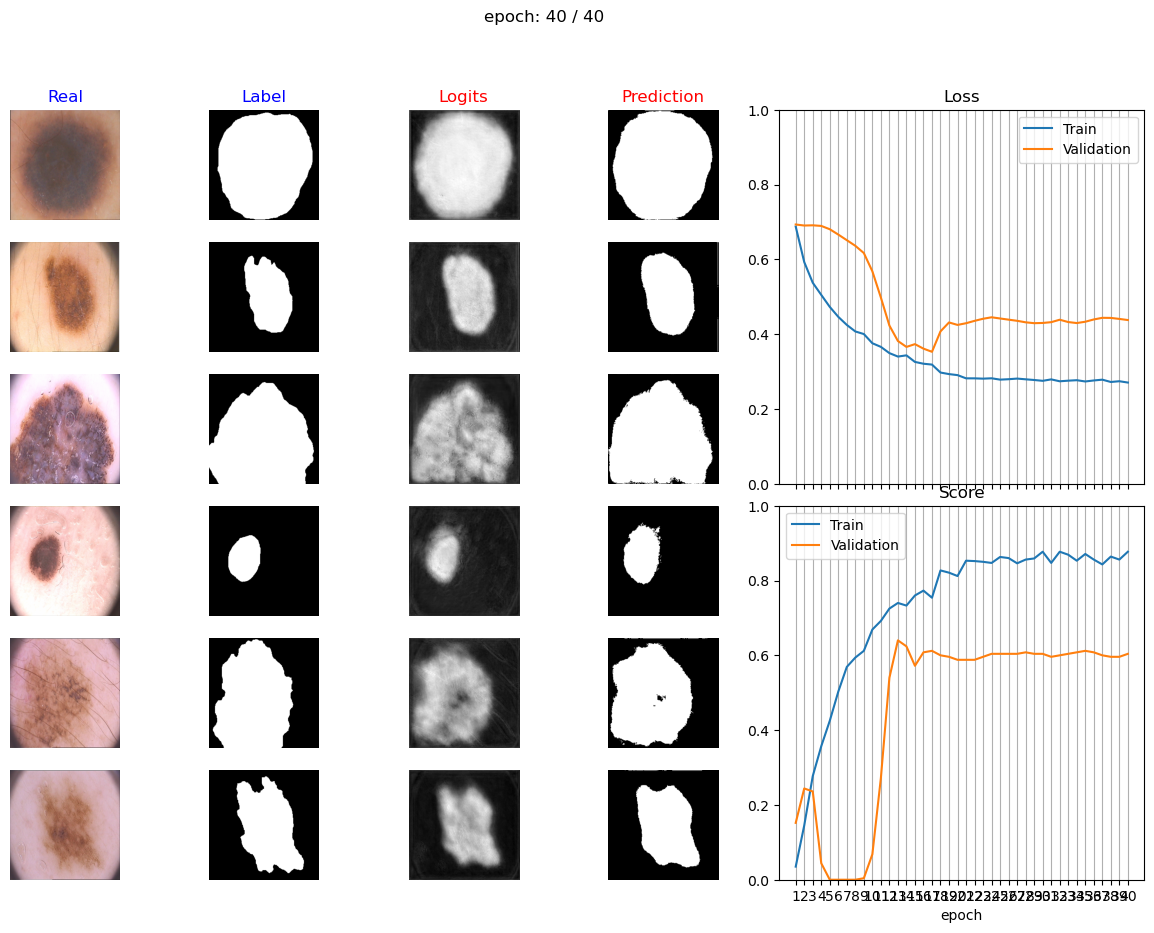

* Epoch 40/40
* Train loss: 0.270491  |  train acc: 0.877000
* Eval  loss: 0.437644  |  eval  acc: 0.604000


In [52]:
unet_model = UNet().to(device)

max_epochs = 40
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.00001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

unet_model_trainer = ModelTrainer()

unet_model_trainer.train(unet_model, optimizer, exp_lr_scheduler, bce_loss,
                         iou_pytorch, max_epochs, data_tr, data_val)


In [54]:
score_model(unet_model, iou_pytorch, data_val)

0.6039999723434448

Так же реализуем эту же архитектуру но с изменением типа пулинга.  
Заменим max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [48]:
class UNet2(nn.Module):
    ''' 
    Модель с convolutions И  transpose-convolutions
    '''

    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=2, stride=2, padding=0)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=2, stride=2, padding=0)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256,
                               kernel_size=2, stride=2, padding=0)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512,
                               kernel_size=2, stride=2, padding=0)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.upsample1 = nn.ConvTranspose2d(
            in_channels=256, out_channels=256, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.upsample2 = nn.ConvTranspose2d(
            in_channels=128, out_channels=128, kernel_size=2, stride=2)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.upsample3 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64, kernel_size=2, stride=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding='same'),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        up0 = self.upsample0(b)
        up0 = torch.concat([up0, e3], dim=1)
        d0 = self.dec_conv0(up0)

        up1 = self.upsample1(d0)
        up1 = torch.concat([up1, e2], dim=1)
        d1 = self.dec_conv1(up1)

        up2 = self.upsample2(d1)
        up2 = torch.concat([up2, e1], dim=1)
        d2 = self.dec_conv2(up2)

        up3 = self.upsample3(d2)
        up3 = torch.concat([up3, e0], dim=1)
        d3 = self.dec_conv3(up3)   # no activation

        return d3


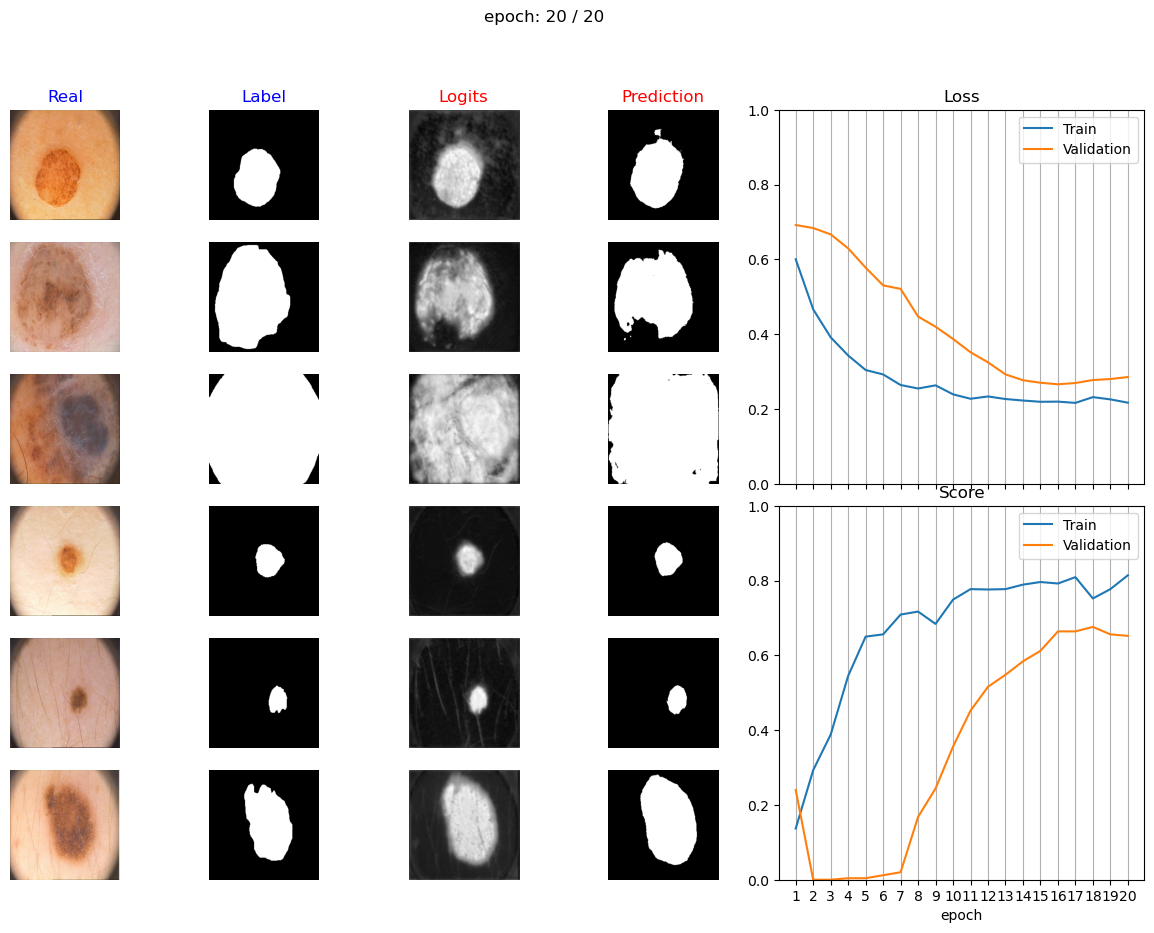

* Epoch 20/20
* Train loss: 0.216657  |  train acc: 0.814000
* Eval  loss: 0.285263  |  eval  acc: 0.652000


In [53]:
unet2_model = UNet2().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(unet2_model.parameters(), lr=0.0001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

unet2_model_trainer = ModelTrainer()

unet2_model_trainer.train(unet2_model, optimizer, exp_lr_scheduler,
                          bce_loss, iou_pytorch, max_epochs, data_tr, data_val)


In [55]:
score_model(unet2_model, iou_pytorch, data_val)

0.6039999723434448

---

# Сравнение различных моделей и лоссов. 


---

Сравним между собой различные лосс функции. Построим графики скора на валидации:

Text(0.5, 1.0, 'Models_SegNet score')

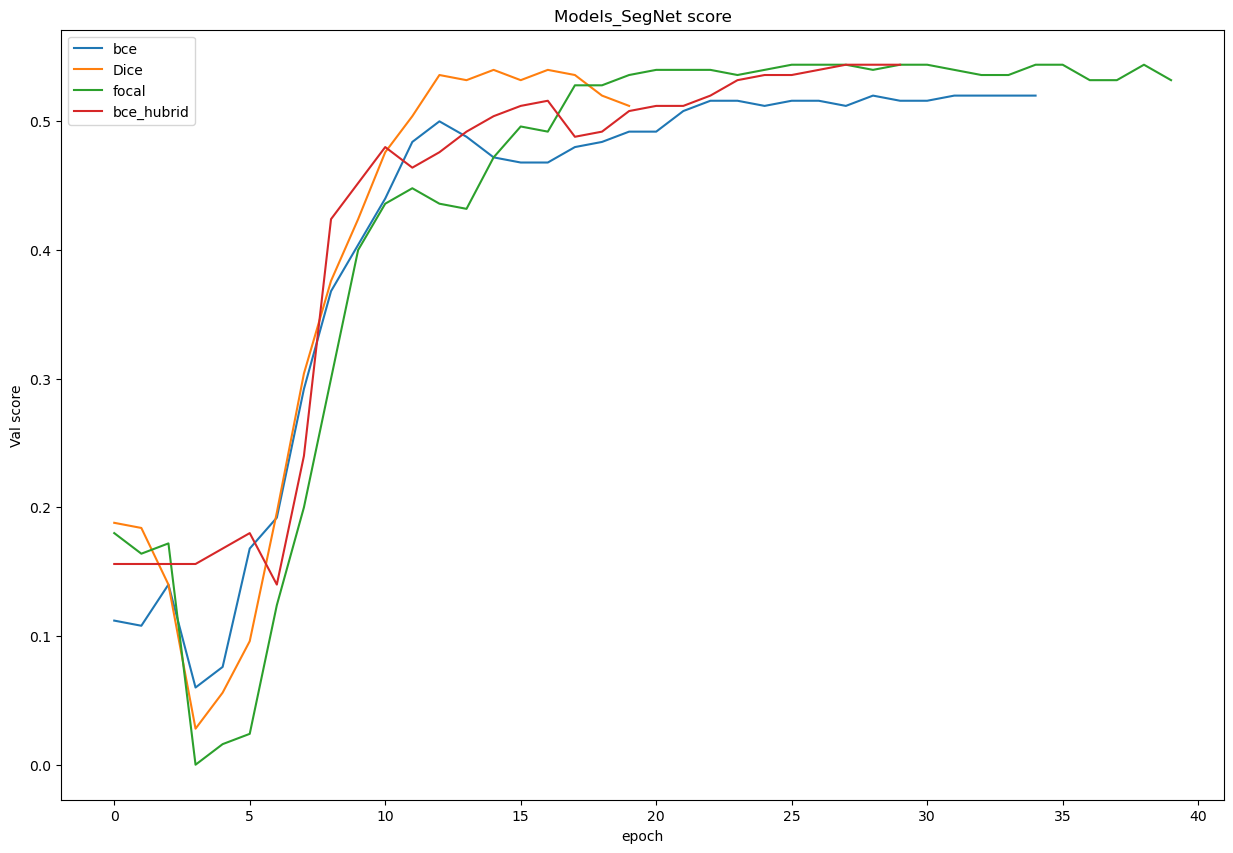

In [120]:
models_Segnet = {'bce': segnet_model_trainer,
                 'Dice': model_trainer_dice,
                 'focal': model_trainer_focal,
                 'bce_hubrid': model_trainer_bce_hybrid,
                 }

plt.figure(figsize=(15, 10))
for mt in models_Segnet.items():
    y = mt[1].eval_hist[1:, 1]
    x = range(len(y))
    plt.plot(x, y, label=mt[0])

plt.xlabel('epoch')
plt.ylabel('Val score')
plt.legend()
plt.title('Models_SegNet score')


В целом все функции имеют схожие графики: они достигают максимума на 10-15 эпохах и имеют скор около 0,50.  
Для того что бы выбрать лучшую построим графики точности на тестовых данных:

Text(0.5, 1.0, 'Differernt loss functions score')

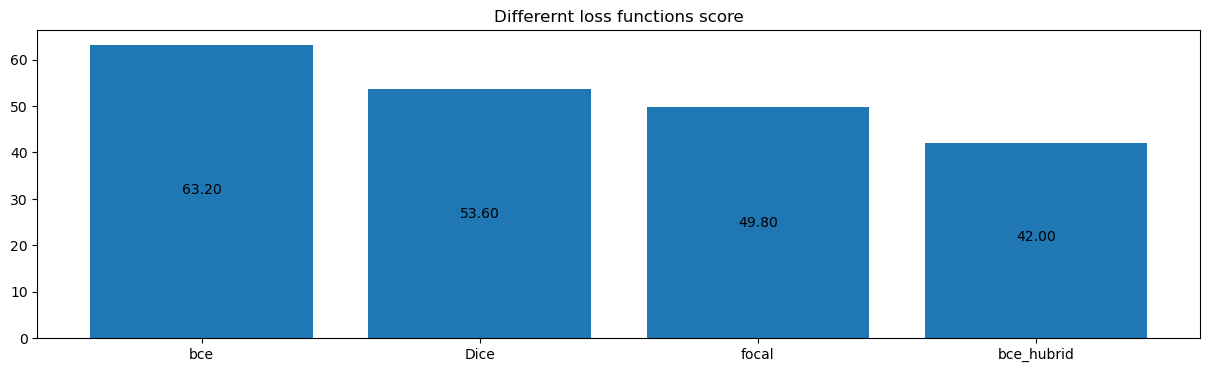

In [122]:
models = {'bce': model_bce,
          'Dice': model_dice,
          'focal': model_focal,
          'bce_hubrid': model_bce_hybrid,
          }

score_test = []
labels = []
for model in models.items():
    score_test.append(score_model(model[1], iou_pytorch, data_ts)*100)
    labels.append(model[0])

plt.bar(labels, score_test)
for i in range(len(labels)):
    plt.text(i, score_test[i]//2, '%.2f' % score_test[i], ha='center')

plt.title('Differernt loss functions score')


Наибольшую точность показывают сети с лосом BCE.   
В дальнейшем мы будем смотреть на различные модели обученные именно с этим лоссом.

Посмотрим на точность различных архитектур и выберем лучшую: выведем графики точности и лоссов и сравним их.  
Так же для сравнения добавим ещё 2 архитектуры с использованием слоя MaxUnpool для апскейлинга в декодере. Изменим сети SegNet и UNet и обучим их с лоссфунцией bce: 

In [57]:
class SegNet_max_unpool(nn.Module):
    ''' 
    Seg net with MaxUnpool upsampler
    '''

    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding='same'),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0, p0_indices = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1, p1_indices = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2, p2_indices = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3, p3_indices = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        up0 = self.upsample0(b, p3_indices)
        d0 = self.dec_conv0(up0)

        up1 = self.upsample1(d0, p2_indices)
        d1 = self.dec_conv1(up1)

        up2 = self.upsample2(d1, p1_indices)
        d2 = self.dec_conv2(up2)

        up3 = self.upsample3(d2, p0_indices)
        d3 = self.dec_conv3(up3)   # no activation

        return d3


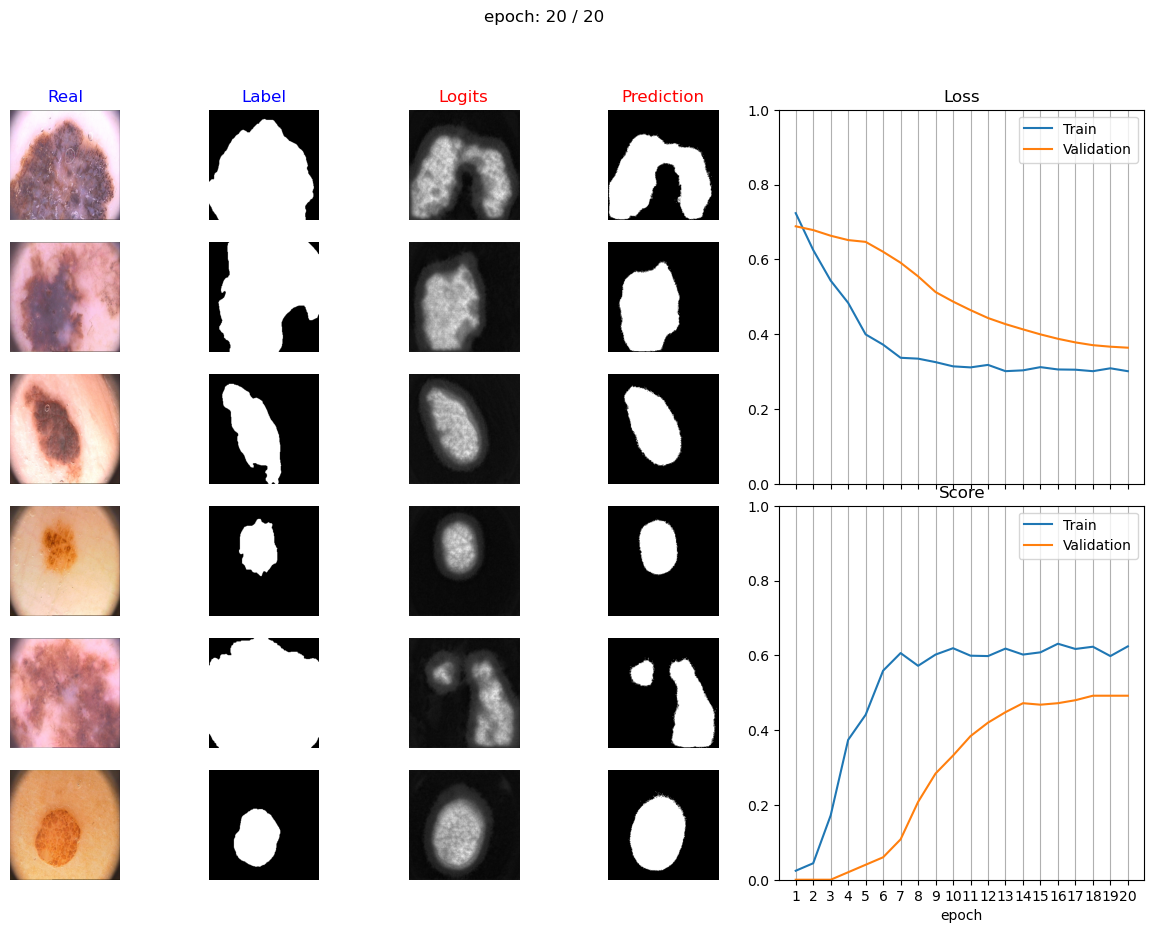

* Epoch 20/20
* Train loss: 0.300840  |  train acc: 0.624000
* Eval  loss: 0.363691  |  eval  acc: 0.492000


In [70]:
model_SegNet_MU = SegNet_max_unpool().to(device)

max_epochs = 20
optimizer = torch.optim.Adam(model_SegNet_MU.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

segnet_maxunpool_model_trainer = ModelTrainer()

segnet_maxunpool_model_trainer.train(
    model_SegNet_MU, optimizer, exp_lr_scheduler, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)


In [64]:
class UNet_max_unpool(nn.Module):
    ''' 
    Модель с convolutions И  transpose-convolutions
    '''

    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding='same'),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding='same'),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0, p0_indices = self.pool0(e0)

        e1 = self.enc_conv1(p0)
        p1, p1_indices = self.pool1(e1)

        e2 = self.enc_conv2(p1)
        p2, p2_indices = self.pool2(e2)

        e3 = self.enc_conv3(p2)
        p3, p3_indices = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        up0 = self.upsample0(b, p3_indices)
        up0 = torch.concat([up0, e3], dim=1)
        d0 = self.dec_conv0(up0)

        up1 = self.upsample1(d0, p2_indices)
        up1 = torch.concat([up1, e2], dim=1)
        d1 = self.dec_conv1(up1)

        up2 = self.upsample2(d1, p1_indices)
        up2 = torch.concat([up2, e1], dim=1)
        d2 = self.dec_conv2(up2)

        up3 = self.upsample3(d2, p0_indices)
        up3 = torch.concat([up3, e0], dim=1)
        d3 = self.dec_conv3(up3)   # no activation

        return d3


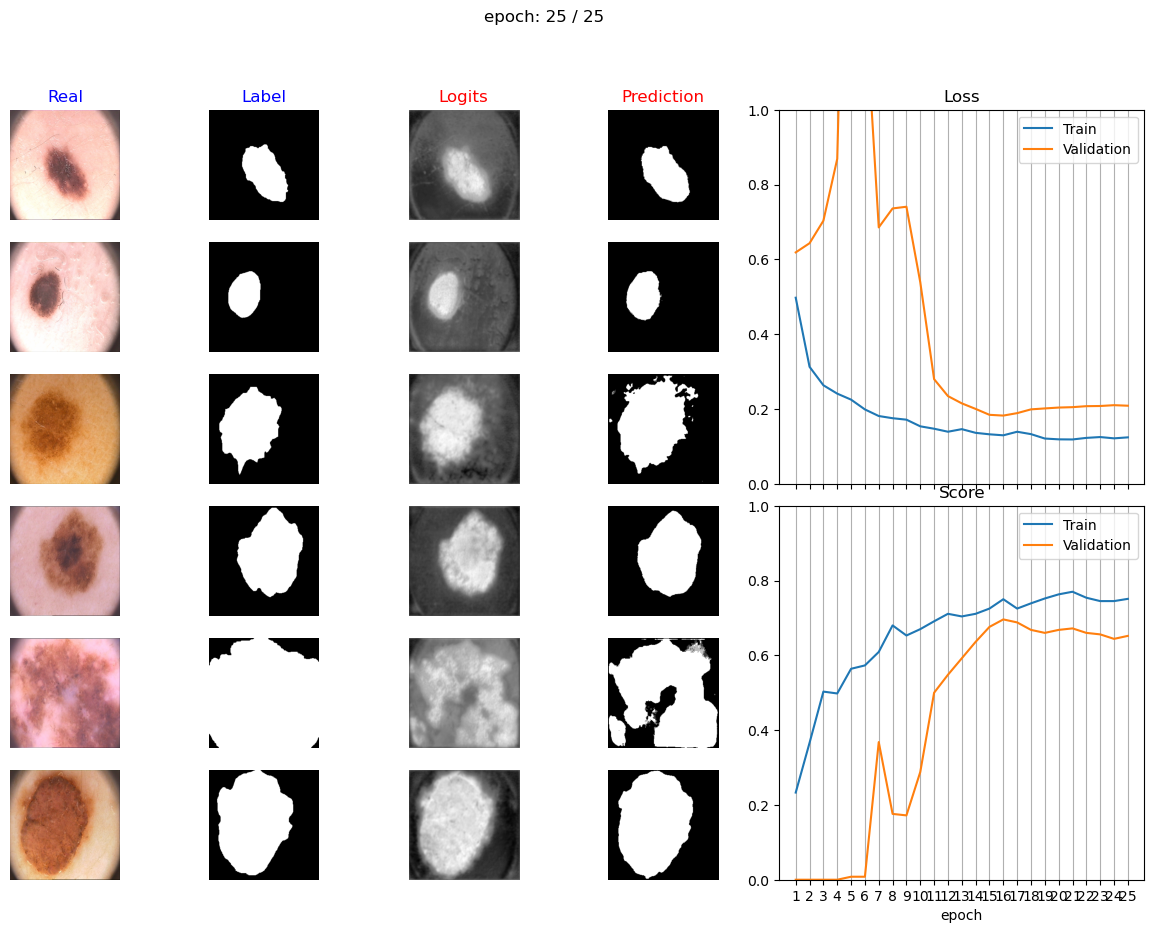

* Epoch 25/25
* Train loss: 0.123969  |  train acc: 0.751000
* Eval  loss: 0.208576  |  eval  acc: 0.652000


In [69]:
model_Unet_MU = UNet_max_unpool().to(device)

max_epochs = 25
optimizer = torch.optim.Adam(model_Unet_MU.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

unet_MU_model_trainer = ModelTrainer()

unet_MU_model_trainer.train(model_Unet_MU, optimizer, exp_lr_scheduler,
                            bce_loss, iou_pytorch, max_epochs, data_tr, data_val)


Всего у нас 5 архитектур сетей:

In [72]:
models = {'segnet': model_bce,
          'Segnet_MU': model_SegNet_MU,
          'Unet': unet_model,
          'Unet2': unet2_model,
          'Unet_MU': model_Unet_MU}


In [76]:
model_trainers = {'segnet': segnet_model_trainer,
                  'Segnet_MU': segnet_maxunpool_model_trainer,
                  'Unet': unet_model_trainer,
                  'Unet2': unet2_model_trainer,
                  'Unet_MU': unet_MU_model_trainer, }


Построим график точности на валидации:

Text(0.5, 1.0, 'Models_BCE score')

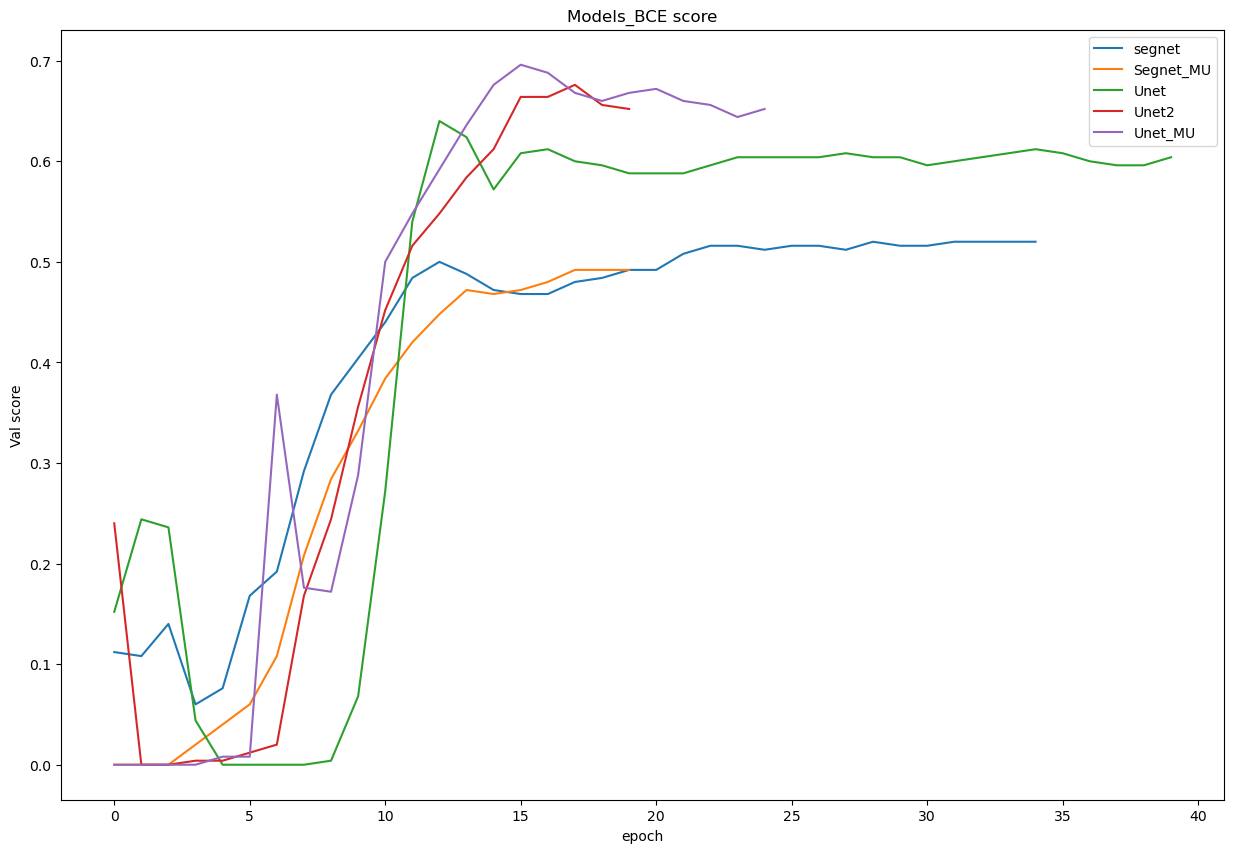

In [107]:
plt.figure(figsize=(15, 10))
for mt in model_trainers.items():
    y = mt[1].eval_hist[1:, 1]
    x = range(len(y))
    plt.plot(x, y, label=mt[0])

plt.xlabel('epoch')
plt.ylabel('Val score')
plt.legend()
plt.title('Models_BCE score')


Построим график loss на валидации:

Text(0.5, 1.0, 'Models_BCE Loss')

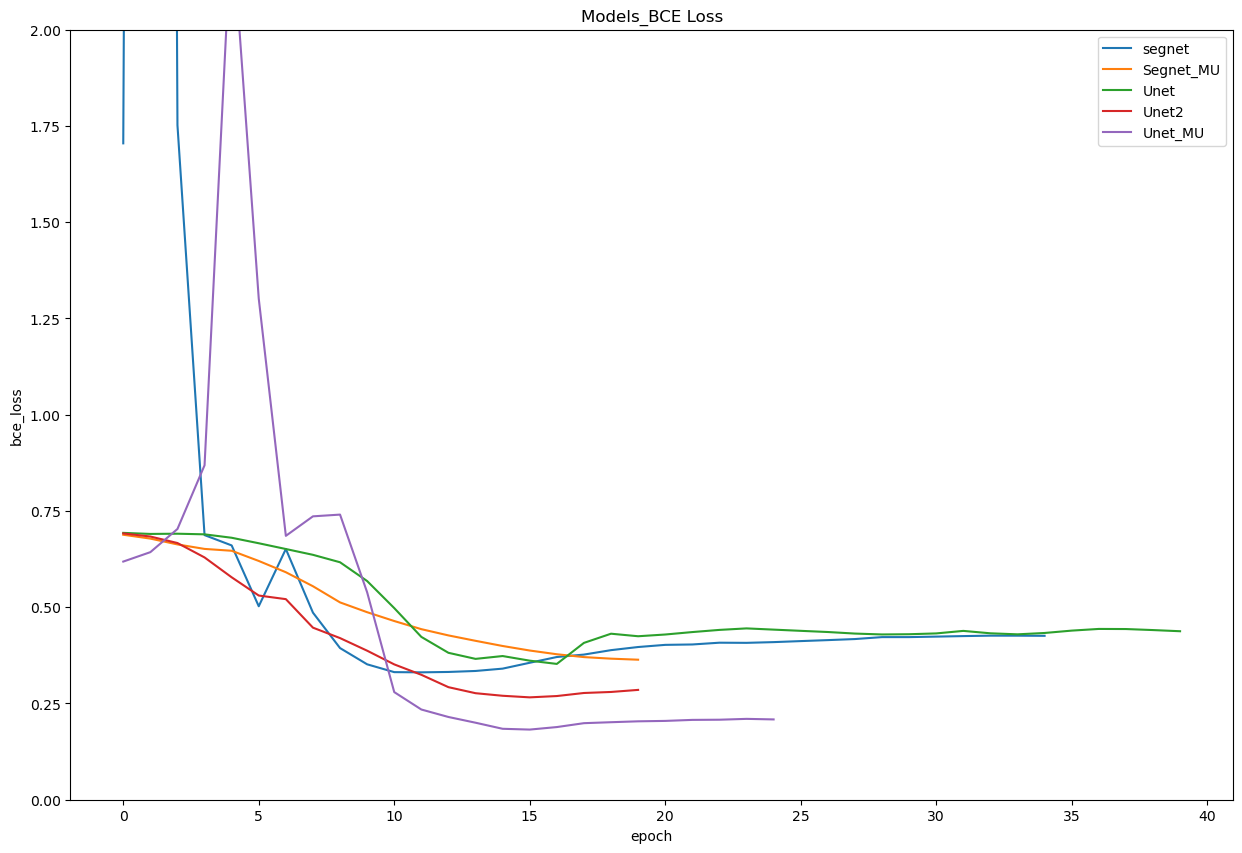

In [106]:
plt.figure(figsize=(15, 10))
for mt in model_trainers.items():
    y = mt[1].eval_hist[1:, 0]
    x = range(len(y))
    plt.plot(x, y, label=mt[0])
plt.ylim((0, 2))
plt.xlabel('epoch')
plt.ylabel('bce_loss')
plt.legend()
plt.title('Models_BCE Loss')


По графикам можно сделать первые выводы:
1. Архитектура UNet показывает более точные результаты. На графике score виден разрыв между данными типами архитектур. Так же они закономерно показвают больший лосс.
2. Из обученных сетей наиболее точной является сеть Unet c MaxUnpool. Почти такой же точностью обладает сеть Unet2.
3. Моделям для обучения достаточно около 10-15 эпох, затем скорее всего начинается переобучение.

Теперь построим график и сравним точность наших моделей на тестовых данных( тех которые сети не видели ни разу):

In [94]:
score_test=[]
labels=[]
for model in models.items():
    score_test.append(score_model(model[1], iou_pytorch, data_ts)*100)
    labels.append(model[0])

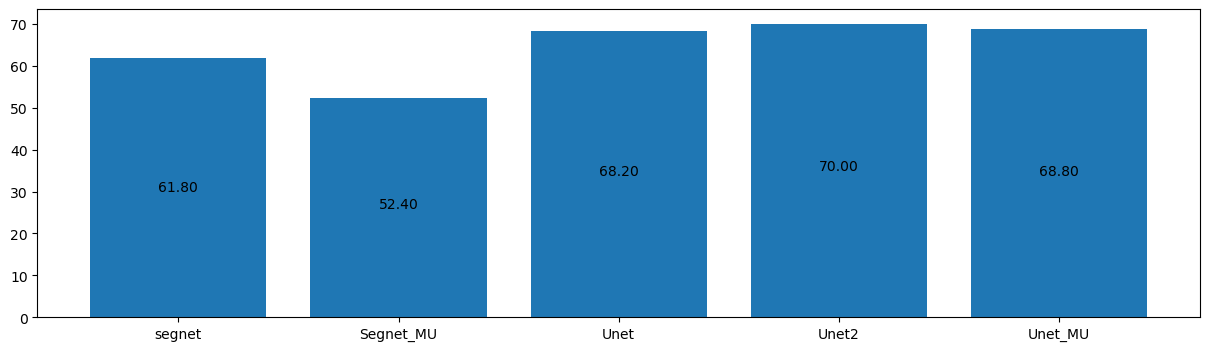

In [105]:
plt.bar(labels,score_test)
for i in range(len(labels)):
    plt.text(i, score_test[i]//2, '%.2f'%score_test[i], ha = 'center')

plt.title()

Сделанные выше выводы подтвердились: Архитектура Unet более точная, Наибольший скор показала сеть Unet2, рядом с ней сеть Unet_MU 

Общие выводы:
1. Архитектуры использующие Skip-connection являются более точными и обучаются быстрее.
2. В целом все модели показали неплохие результаты: 60-70%
3. Для увеличения точности сетей можно: точнее подобрать параметры оптимизатора, увеличить датасет путём аугментаций.
4. Наибольшая точность наших моделей была при функции потерь bce.
4. Выбор функции потерь зависит от решаемой задачи: некоторые функции лучше определяют тонкие линиии, некоторые - определяют большие области, гладкие границы или наборот неровные.